## 3. Structure discovery for the Lorenz-96 problem

In this notebook, we will show how we can estimate the conditional independence structure of a random variable $\mathsf{X} \in \mathbb{R}^{N_x}$ with density $\pi$ based on i.i.d. samples $\{\boldsymbol{x}^i\}, \; i = 1, \ldots, N_e$ from $\pi$.

References: 

[1] Lorenz, E.N., 1996, September. Predictability: A problem partly solved. In Proc. Seminar on predictability (Vol. 1, No. 1).

[2] Baptista, R., Zahm, O., & Marzouk, Y. (2020). An adaptive transport framework for joint and conditional density estimation. arXiv preprint arXiv:2009.10303.

[3] Baptista, R., Marzouk, Y., Morrison, R.E. and Zahm, O., 2021. Learning non-Gaussian graphical models via Hessian scores and triangular transport. arXiv preprint arXiv:2101.03093.


In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq
using ProgressMeter

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116


Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# Plots.font("sans-serif")
# clibrary(:colorbrewer)
# gr()
pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["text.usetex"] = true;
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

using ColorSchemes

The Lorenz-96 model [1] is a famous problem used in data assimilation and weather prediction. It was derived from first principles as a one-dimensional model for the response of the mid-latitude atmosphere to forcing input. For certain forcing input, it can exhibit a chaotic behavior: sensitivity to initial conditions, strong mixing. In this notebook, we consider the fifteen-dimensional version of the Lorenz-96 model.  The state $\boldsymbol{x} = (x_1, \ldots, x_{15})$ at time $t$ is governed by the following set of ordinary differential equations:  

\begin{equation}
    \frac{\mathrm{d}x_i}{\mathrm{d}t} = (x_{i+1} - x_{i-2}) x_{i-1} -x_i + F,
\end{equation}
where it is assumed that $x_{-1} = x_{n − 1} , x_0 = x_{n}$ and $x_{n+1} = x_1$, setting the forcing input $F=8.0$ leads to chaos.

We integrate the Lorenz-96 problem with our favorite ODE library: OrdinaryDiffEq.jl.

In [3]:
function lorenz96!(du,u,p,t)
    F = 8.0
    n = size(u,1)
    du[1] = (u[2]-u[end-1])*u[end] - u[1] + F
    du[2] = (u[3]-u[end])*u[1] - u[2] + F
    du[end] = (u[1] - u[end-2])*u[end-1] - u[end] + F

    @inbounds for i=3:n-1
        du[i] = (u[i+1] - u[i-2])*u[i-1] - u[i] + F
    end
    return du
end

lorenz96! (generic function with 1 method)

In [51]:
# Define the distribution for initial condition
Nx = 20
# Number of runs
Ne = 500
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz96!,x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: 20-element Array{Float64,1}:
 -0.5901971392068536
  0.39478770854432377
 -0.9782033574150046
 -0.22024619340106624
 -0.8394683233148887
  0.7852932777661026
 -0.8201363233707767
  1.2932492486959453
 -1.363092127868417
 -0.5814537134272362
  0.9780347874070602
  0.5766977457297677
  0.6590533906875842
  0.6669303405271328
  1.6714289713704404
 -1.0307067482720573
 -0.07787630196744173
 -0.7693031317820128
  0.08699657661085415
  1.2810036267757885

Create cache to store the different final solutions

In [52]:
X = zeros(Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`

In [53]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    X[:,i] = deepcopy(sol.u[1])
end

We can use the adaptive transport map procedure to estimate the underlying distribution for the state $\mathsf{X}$.

In [82]:
λ = 0.0
δ = 1e-8
γ = 2.0

@time S = SparseRadialMap(Nx, -1; λ = λ, δ = δ, γ = γ)

  0.000041 seconds (951 allocations: 84.469 KiB)


Sparse Radial Map of dimension Nx = 20 and order p = [[-1], [-1, -1], [-1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)


In [85]:
using BenchmarkTools

In [86]:
@btime begin 
    S = SparseRadialMap(Nx, -1; λ = λ, δ = δ, γ = γ)
    optimize(S, X, 2, 1, "kfolds"; verbose = false)
end

  930.119 ms (11386774 allocations: 1.49 GiB)


Sparse Radial Map of dimension Nx = 20 and order p = [[1], [2, 1], [2, 2, 1], [2, 2, 2, 1], [2, -1, 2, 2, 1], [2, 2, 2, 2, 2, 1], [-1, 2, 2, 2, 2, -1, 1], [2, 2, 2, 2, 2, 2, 2, 1], [2, 2, 2, -1, 2, 2, 2, 2, 1], [2, -1, 2, -1, 2, 2, 2, 2, 2, 1], [-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, 1], [2, -1, 2, -1, -1, -1, 2, 2, 2, 2, -1, 1], [2, -1, 2, -1, -1, -1, -1, -1, -1, 2, 2, -1, 1], [2, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, 1], [2, -1, 2, -1, -1, -1, -1, -1, -1, 2, -1, -1, 2, 2, 1], [2, 2, 2, -1, 2, -1, -1, -1, -1, 2, -1, -1, -1, 2, -1, 1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, 1], [2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, 1], [2, 2, 2, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, 2, 2, 1], [2, 2, 2, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, 2, -1, 1]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)


In [57]:
order = fill(-1, (Nx, Nx))

for i=1:Nx
    view(order,i,1:i) .= S.p[i]
end

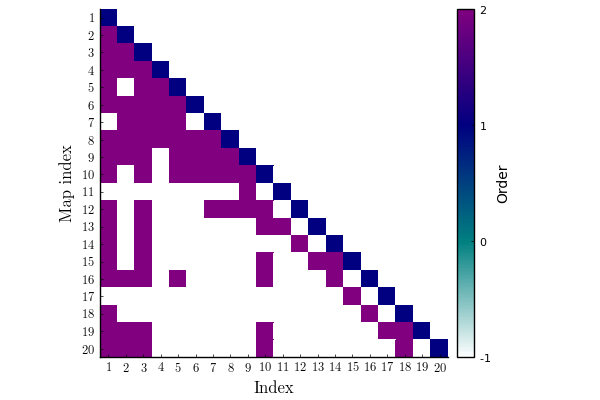

In [80]:
plot(S)

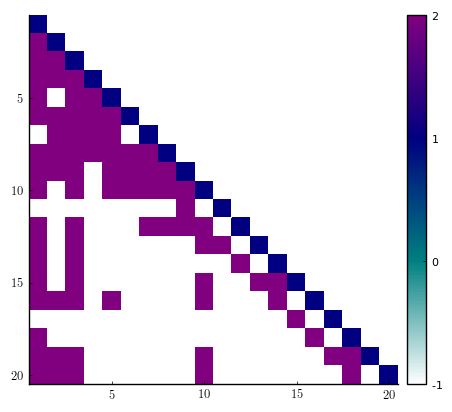

In [58]:
heatmap(order, yflip = true, ratio = 1, color = cgrad([:white, :teal, :navyblue, :purple]))
savefig("radialmap_Lorenz96_structure.pdf")

In [67]:
SpushX = S(X)

20×500 Array{Float64,2}:
 -0.339433  -0.204719   -0.875541     …  -0.655298   0.243134    0.776783
 -1.23045   -1.89291    -0.17724          0.887493  -1.42605     0.440173
 -0.965185  -0.6666     -0.397047         1.20678   -0.129728    0.516596
 -0.991359   1.91401     1.99899         -0.793543   1.60683     0.0285819
  0.729749   0.0217032   1.00762          0.642489  -1.16443    -1.50505
  1.12028    1.26267    -0.795134     …  -0.34673    0.842495   -0.42077
  0.293599   1.82212     0.645063         0.474779  -0.760496   -0.846265
  2.03736   -0.786459   -0.107551        -0.357772  -0.0945134  -0.182125
  1.07523    0.757135   -0.0218839       -1.89061    0.563188    0.119089
 -0.111753  -2.92356     0.26566         -0.285016  -2.22325    -1.64374
  1.44674   -1.27796    -1.37543      …   1.9629     0.0765255   0.203902
 -0.621854   0.862049   -0.371249        -1.91671   -1.18463    -1.22939
 -0.927222  -0.23515    -0.826029        -0.438996   0.32424     1.26891
 -0.629207   0.54

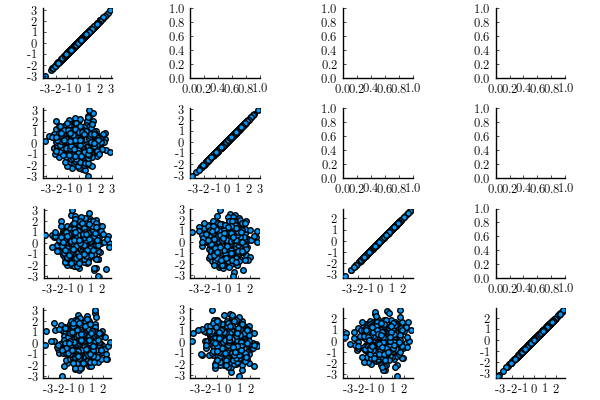

In [72]:
plt = plot(layout = grid(4,4), legend = false, ratio = 1)

for i=1:4
    for j=1:i
    scatter!(plt[i,j], SpushX[i,:], SpushX[j,:])
    end
end
plt

Baptista et al.[3] showed that the conditional independence properties of a random variable $\mathsf{X} \in \mathbb{R}^n$ with density $\pi$ are specified by the *Hessian score matrix* $\boldsymbol{\Omega} \in \mathbb{R}^{n \times n}$ defined as:

\begin{equation}
\Omega_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2  \right] = \int |\partial_i\partial_j \log \pi(\boldsymbol{x})|^2 \pi(\boldsymbol{x}) \; \mathrm{d}\boldsymbol{x}.
\end{equation}

The pullback density $\boldsymbol{S}^{\sharp} \rho$ can be used to approximate the true density $\pi$, where $\rho$ denotes the standard Gaussian distribution of $\mathbb{R}^n$. Thus, the score matrix is estimated by [3]: 
\begin{equation}
\hat{\Omega}_{i,j} = \mathrm{E}_{\pi} \left[ |\partial_i\partial_j \log \boldsymbol{S}^{\sharp} \rho|^2  \right]
\end{equation}

In practice, we use a sampled-based approximation of $\hat{\boldsymbol{\Omega}}$ using samples $\{\boldsymbol{x}^k\}, \; k=1,\ldots, N_e$ of $\pi$ [3]:


\begin{equation}
\hat{\Omega}_{i,j} \approx \sum_{k=1}^{N_e}|\partial_i\partial_j \log \boldsymbol{S}^{\sharp}\rho(\boldsymbol{x}^k )|^2
\end{equation}

The function `hess_x_log_pdf!` computes in-place the Hessian of the log pdf of the pullback density $\boldsymbol{S}^{\sharp} \rho$. You can also use `hess_x_log_pdf`.

In [18]:
Ωhat = zeros(Nx, Nx)
cache = zeros(1, Nx, Nx)
@showprogress for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


15×15 Array{Float64,2}:
     4.90708e5    441.481     11414.6        …  9622.74         631.448
   441.481          7.1244e5    409.046         1393.69           0.0
 11414.6          409.046         3.75106e5     2151.42         106.842
    12.1883     12859.4          50.4824           4.80565        0.0
    14.2867      1203.55      19012.1            251.675          0.0
    26.0031      3786.77         16.3586     …     8.64355      202.812
   841.125         24.8467      246.088            0.0            0.0
    51.2645         0.962193    520.471            1.56015        7.82402
   101.178         10.657         4.8528           9.50035      268.254
     1.84552        9.39884      22.1943         421.593        164.217
   521.527          1.89079       1.40687    …    11.0213        61.5223
    68.5322       161.799       170.027         7150.05           7.64101
    69.152          2.46953       0.881189      2074.26        9123.54
  9622.74        1393.69       2151.42      

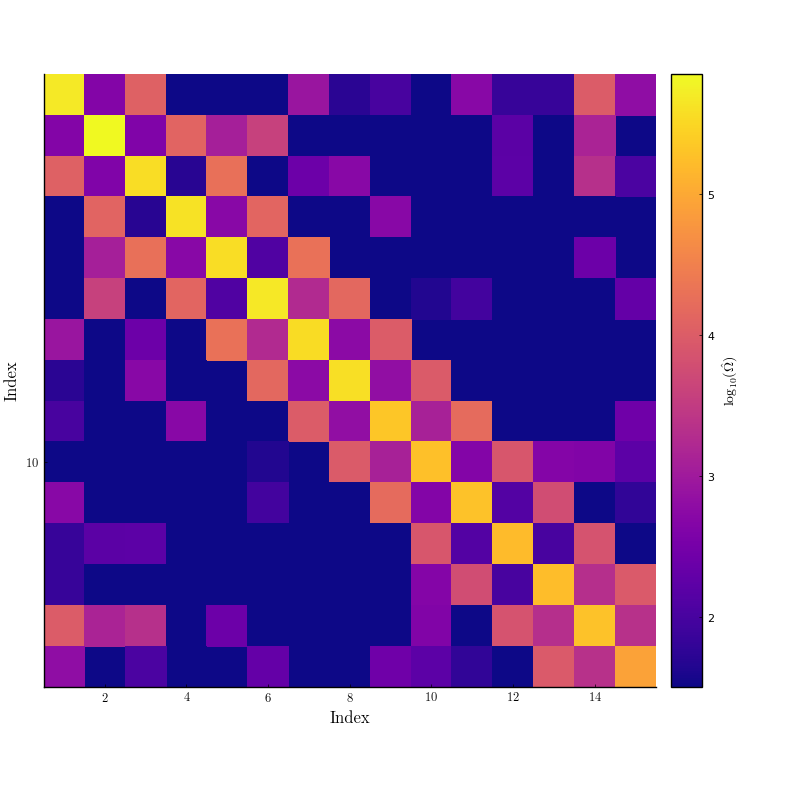

In [19]:
plt = plot(size = (800, 800))

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt